<a href="https://colab.research.google.com/github/sofi444/notebooks/blob/main/BMW_langchain_presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

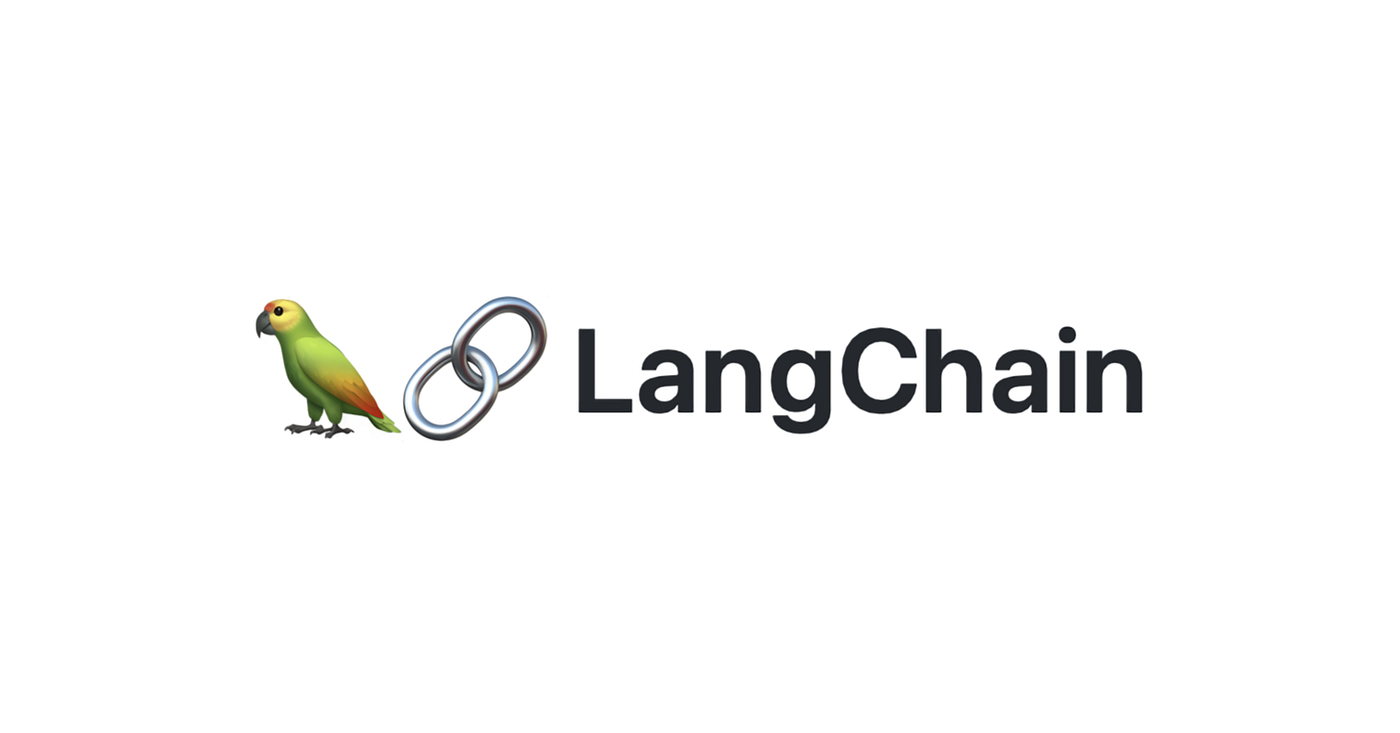

# Set up

In [ ]:
!pip install python-dotenv langchain openai tiktoken chromadb yt_dlp pydub

In [ ]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
_

True

# Intro

Prompting a LLM \\

```
prompt > LLM > output
```

* One-off operation

\\

In most cases, building applications that use LLMs involves

* Prompting the model multiple times
* Storing outputs
* ``` do_something_with_these_outputs() ```
* connect with different tools


\\

**LangChain provides the glue needed to connect these operations**


## Chains

Simple:
- 1 input
- output of one component is the input of another components
- 1 final output

\\

But chains can be more sophisticated and allow the creation of complex pipelines

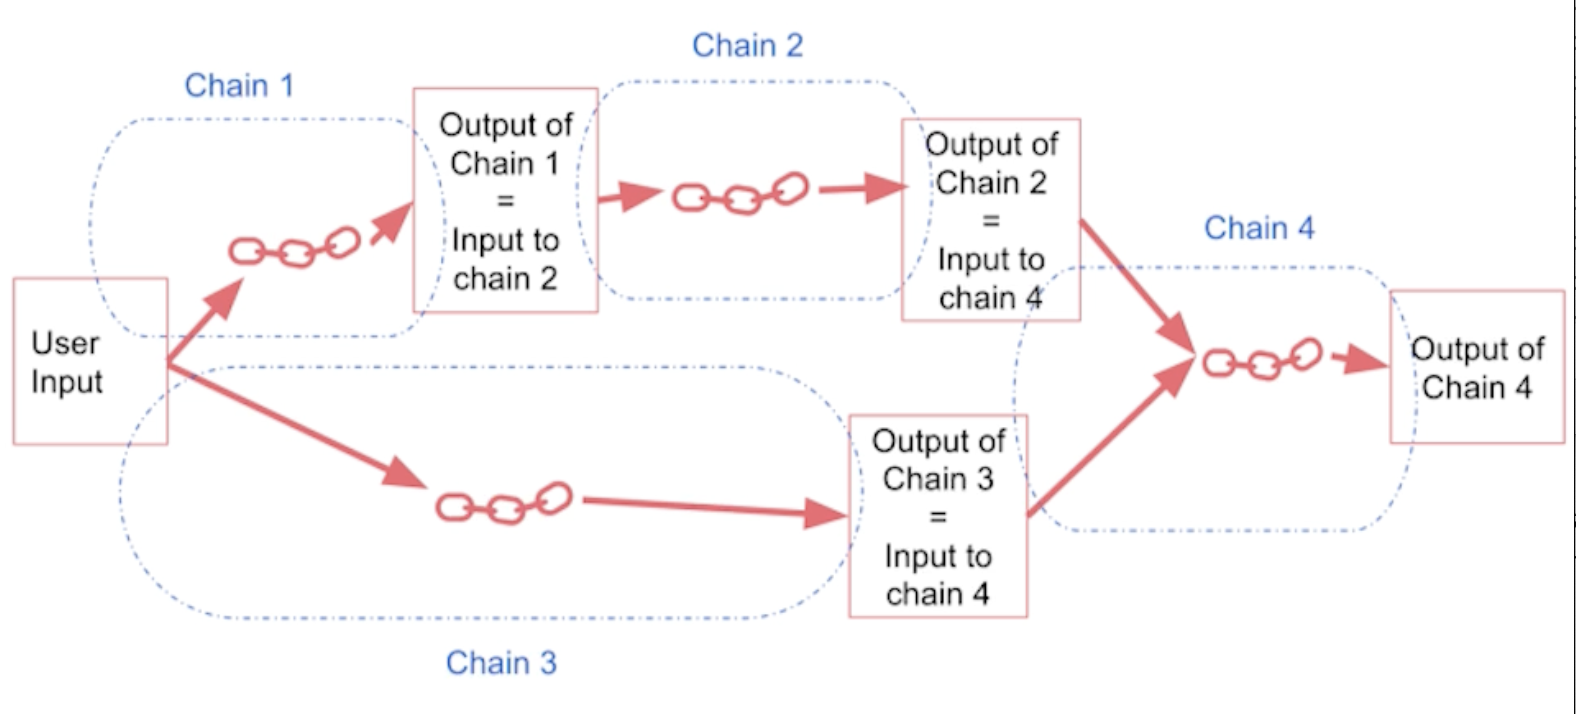

## Prompt Templates

In [ ]:
from langchain import PromptTemplate

template = """
You are a comedian. Your job is to come up with jokes about companies.
Come up with a joke about {company}.
The joke should be witty and {adjective}.
"""

prompt = PromptTemplate(
    input_variables=["company", "adjective"],
    template=template
)

print(prompt.format(company="BMW", adjective="short"))


You are a comedian. Your job is to come up with jokes about companies.
Come up with a joke about BMW.
The joke should be witty and short.



## Models

Here: gpt-3.5-turbo by OpenAI \\

❗ you cannot use the ChatGPT API via the server \\

- BMW version coming soon
- API access (?)

\\

You don't have to use OpenAI models at all >> free + open-source \\

LangChain model integrations:

https://python.langchain.com/docs/modules/model_io/models/

\\

HuggingFace models:

https://huggingface.co/models

\\

❗ do pay attention to licences as some don't allow models to be used for commmercial purposes

In [ ]:
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI(temperature = 1)

In [ ]:
from langchain.chains import LLMChain # Simplest chain!

llm_chain = LLMChain(
    llm=llm,
    prompt=prompt,
    verbose=True
)

In [ ]:
llm_chain.run(company="BMW Group", adjective="short")



> Entering new  chain...
Prompt after formatting:

You are a comedian. Your job is to come up with jokes about companies.
Come up with a joke about BMW Group.
The joke should be witty and short.


> Finished chain.


'Why did the BMW Group start making bicycles? Because two wheels are cheaper than four!"'

## Agents

A story for another time, but the idea is that:

- LLMs can interact with external tools
- Agents can choose which tool is most suitable for solving a task
- Tool runs and then the Agent formats it back to natural language

\\

e.g. Math - LANGUAGE models don't excel at this, better to restrict the scope of their job sometimes..

# Chat with data - Retrieval Augmented Generation (RAG)

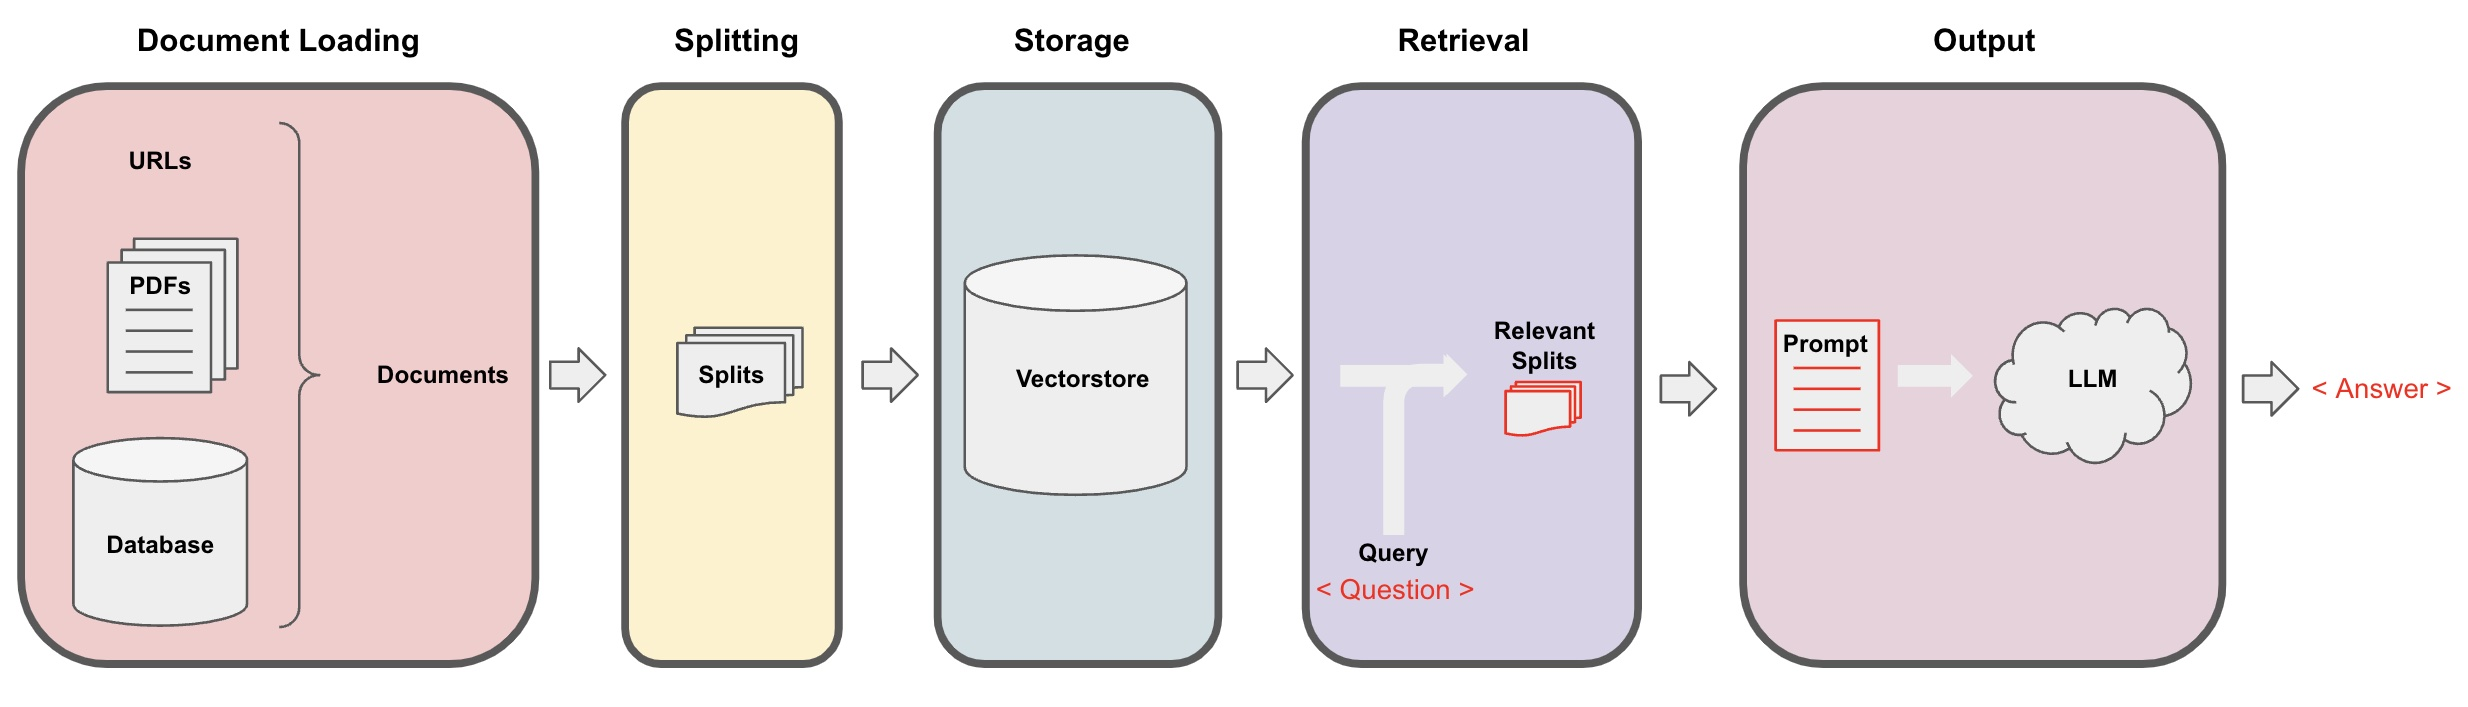

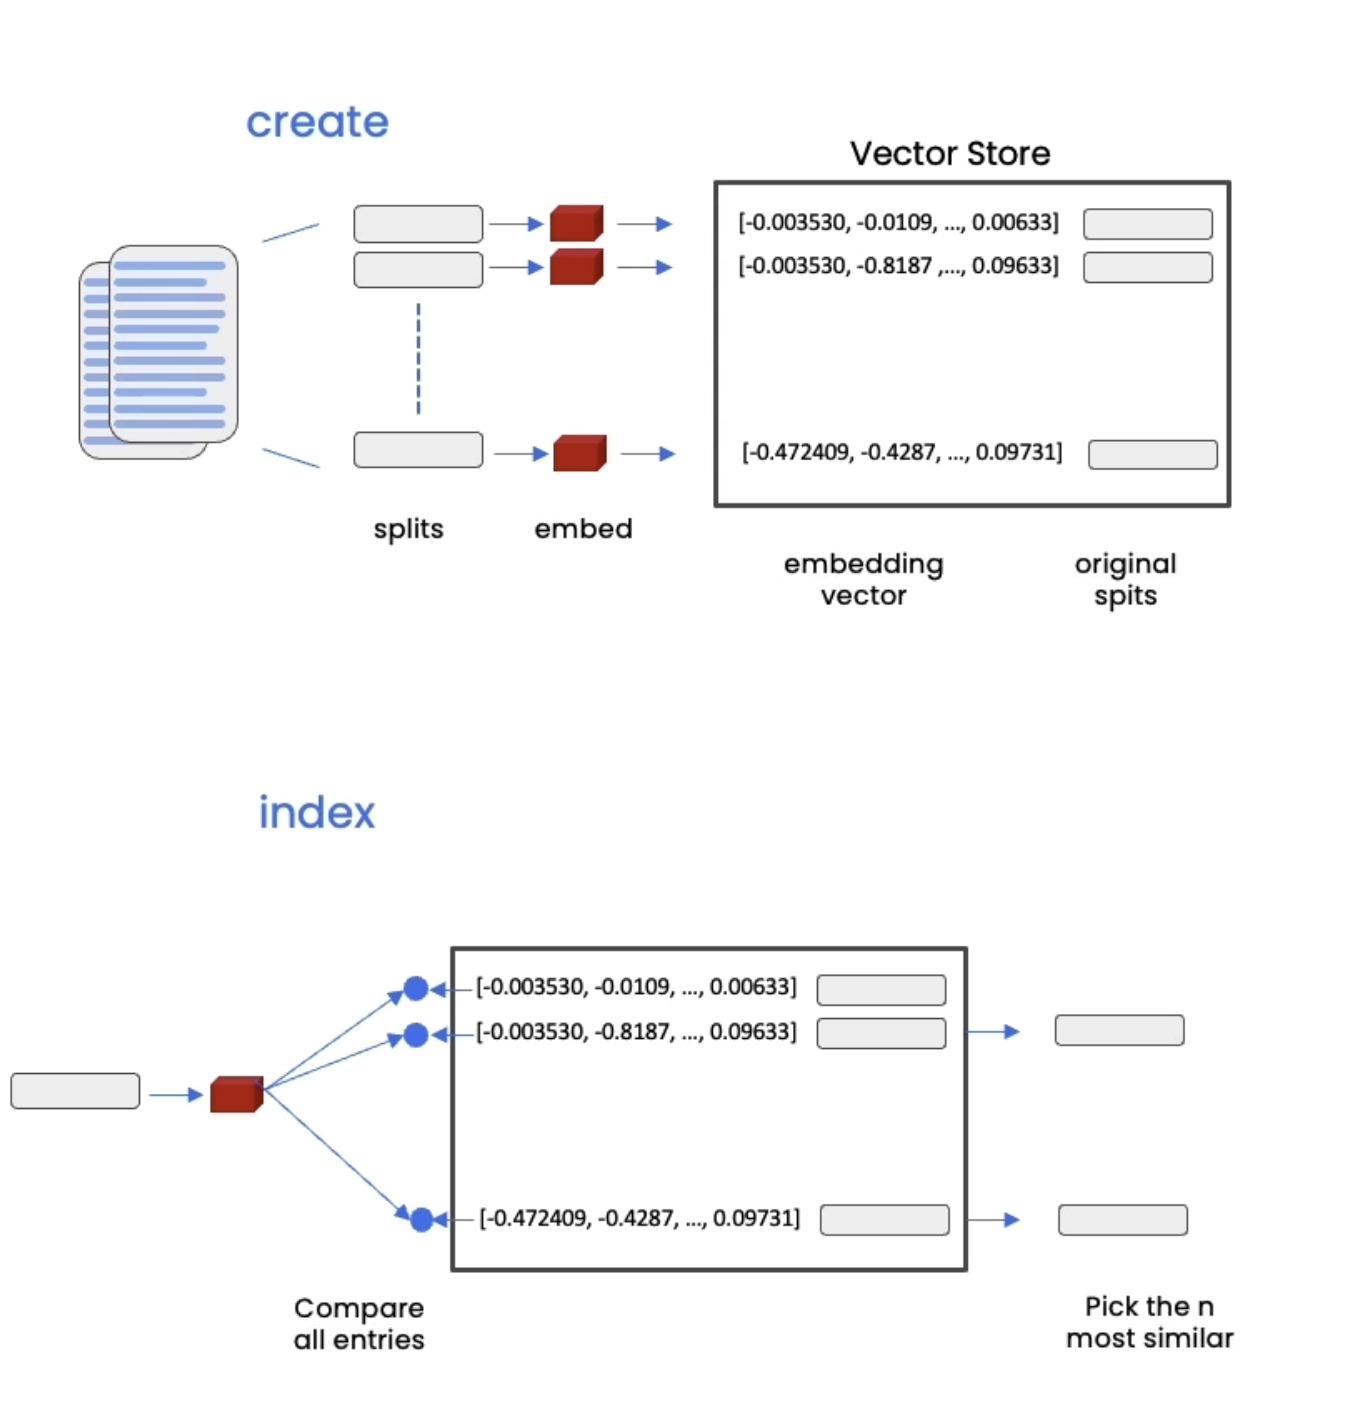

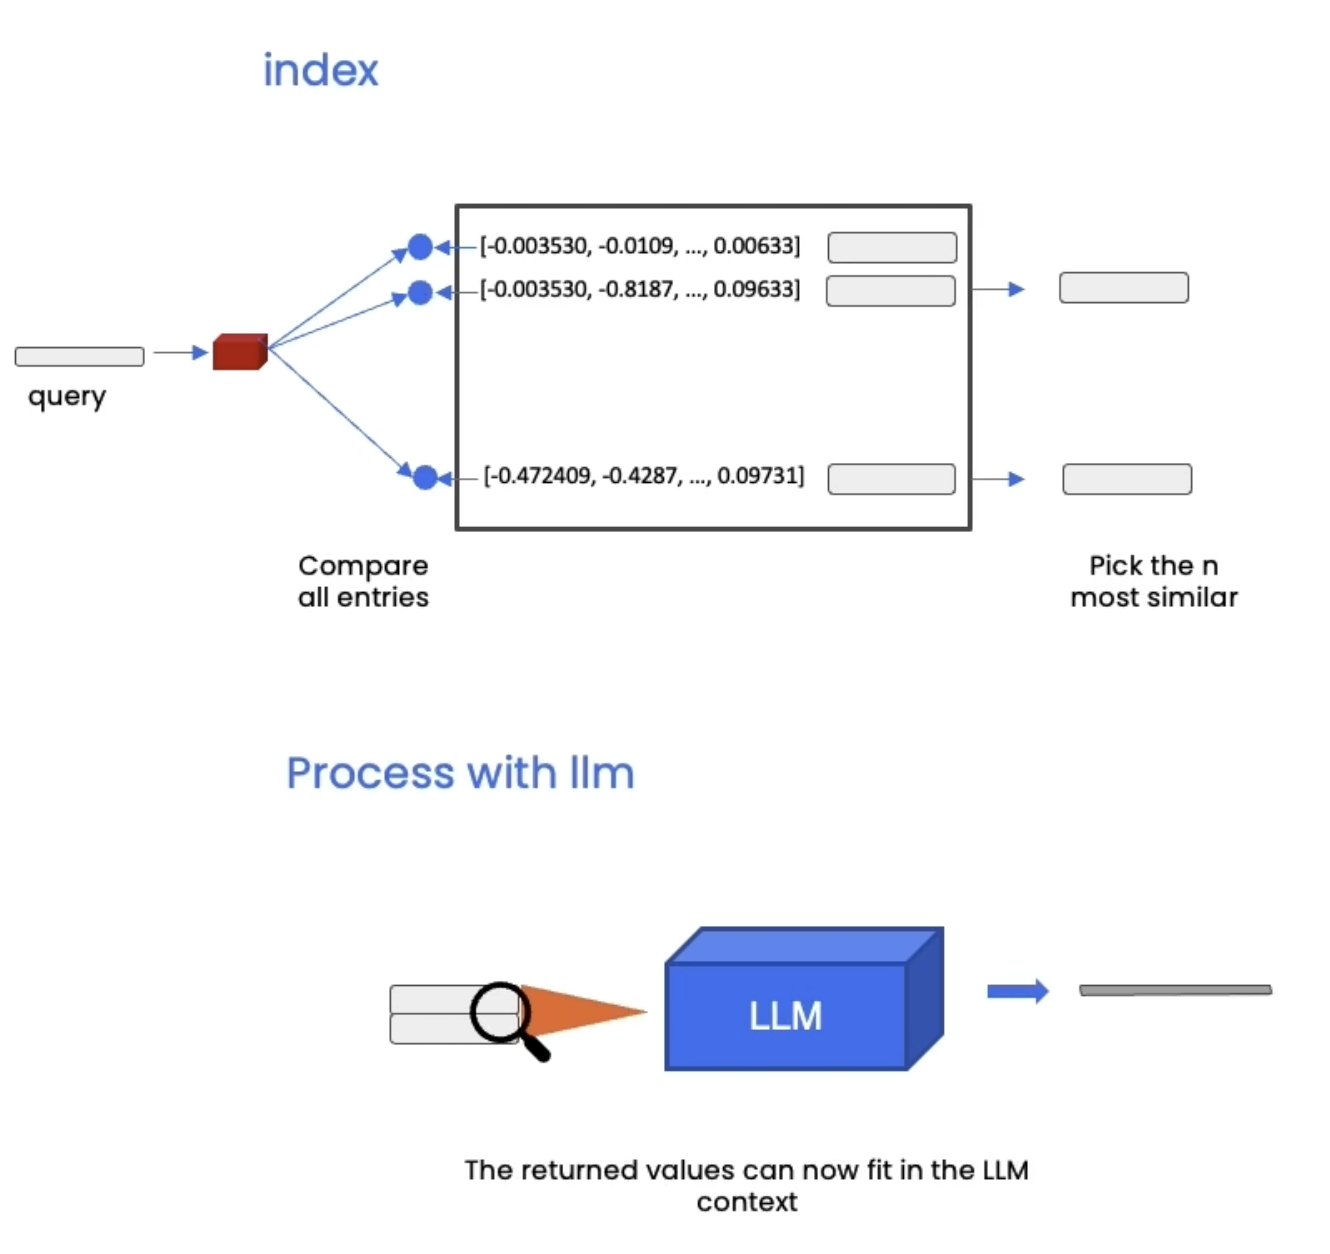

## Load data - Document Loaders

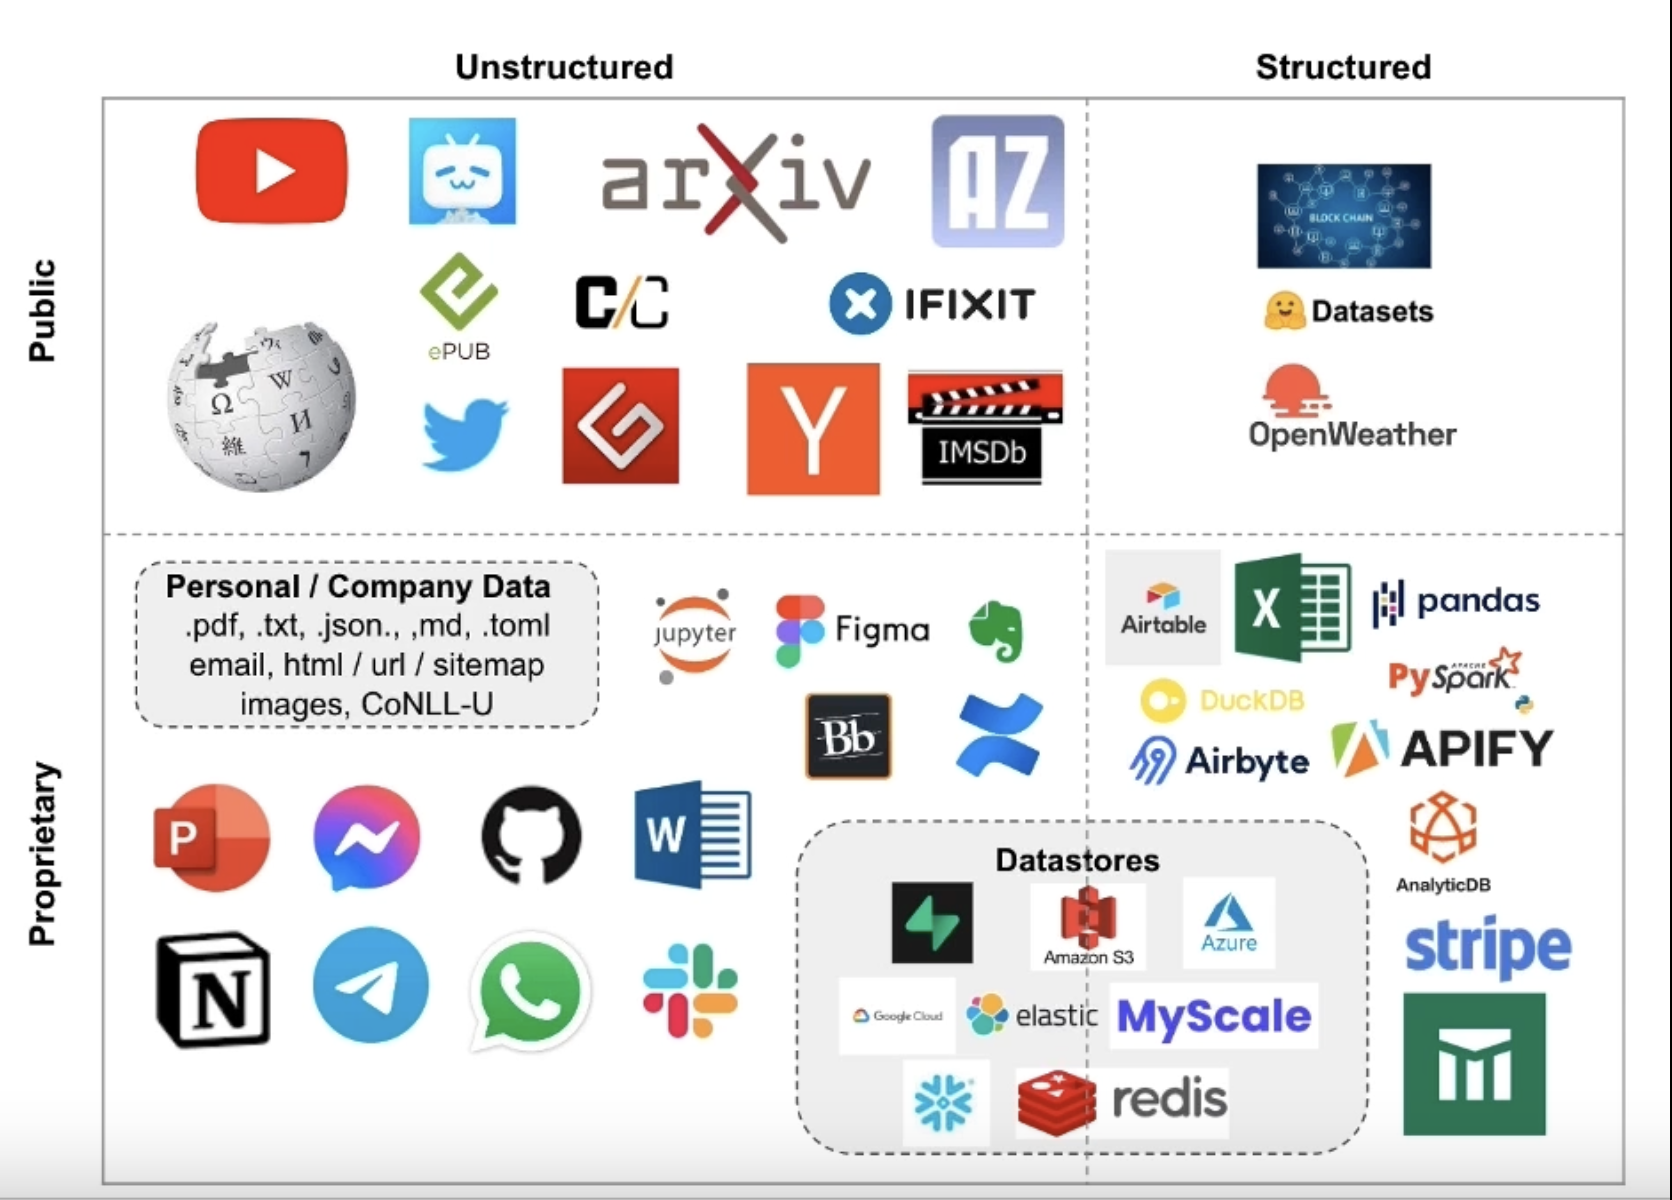

In [ ]:
from langchain.document_loaders.generic import GenericLoader
from langchain.document_loaders.parsers import OpenAIWhisperParser
from langchain.document_loaders.blob_loaders.youtube_audio import YoutubeAudioLoader

video_url = "https://www.youtube.com/watch?v=MUdJyNMx8kc"

loader = GenericLoader(
    YoutubeAudioLoader([video_url], "docs/youtube/"),
    OpenAIWhisperParser()
)

docs = loader.load()

[youtube] Extracting URL: https://www.youtube.com/watch?v=MUdJyNMx8kc
[youtube] MUdJyNMx8kc: Downloading webpage
[youtube] MUdJyNMx8kc: Downloading ios player API JSON
[youtube] MUdJyNMx8kc: Downloading android player API JSON
[youtube] MUdJyNMx8kc: Downloading m3u8 information
[info] MUdJyNMx8kc: Downloading 1 format(s): 140
[download] Destination: docs/youtube//All You Need to Know ｜ The new 3 Series.m4a
[download] 100% of   11.46MiB in 00:00:00 at 27.78MiB/s  
[FixupM4a] Correcting container of "docs/youtube//All You Need to Know ｜ The new 3 Series.m4a"
[ExtractAudio] Not converting audio docs/youtube//All You Need to Know ｜ The new 3 Series.m4a; file is already in target format m4a
Transcribing part 1!


In [ ]:
docs

[Document(page_content="Hi, my name is James. For over 45 years, the worldwide success of the BMW 3 Series represents the core of the BMW brand. Young, sporty, enthusiastic, the 3 embodies the pure driving pleasure that has set the benchmark in the premium segment mid-size class. As every seventh BMW sold worldwide as a 3 Series, it is the BMW Group's best-selling series. This shows how popular it is for the customer and how important it is for BMW. The new BMW 3 Series comes with design modifications that emphasize its precise and dynamic character even more intensively. As in 2019, the 3 brings several updates in design and technology that will later be adopted by other BMW models. The new BMW 3 Series comes with a new customer-centric offer structure. The customer now benefits from the standardization of a lot of special equipment and a simplified offer structure of new packages. The sportline aesthetics now come as standard equipment. Those who want a more muscular look can choose 

## Split docs - Splitters

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=100
)

split_docs = r_splitter.split_documents(docs)

len(split_docs)

29

## Embed data - Embeddings

In [ ]:
from langchain.embeddings.openai import OpenAIEmbeddings
embedding = OpenAIEmbeddings()

## Store embeddings - Vector Stores

In [ ]:
from langchain.vectorstores import Chroma

vectordb = Chroma.from_documents(
    documents=split_docs,
    embedding=embedding,
    persist_directory='docs/chroma/'
)

100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


In [ ]:
print(vectordb._collection.count())

47


In [ ]:
#!rm -rf docs/chroma
vectordb.persist()

## Answer a question - Similarity Search

In [ ]:
question = "what are the characteristics of the exterior design?"

In [ ]:
ss_results = vectordb.similarity_search(question, k=3)
ss_results

[Document(page_content='daytime running lights and from now on, also the turn indicator. The front bumper here comes with a big hexagonal air intake in the centre which is inspired by motorsport design and makes a strong visual statement. Towards the side, the vertical air curtains emphasise the wide stance and form a distinctive shark nose. At the side, the short overhangs, the long bonnet and the long wheelbase convey dynamism even at a standstill. What you can see here is the 19-inch M light alloy wheel double spoke styling 791M in bi-colour jet black. At the rear, there are the slim, elegant rear lights, while', metadata={'source': 'docs/youtube/All You Need to Know ｜ The new 3 Series.m4a', 'chunk': 0}),
 Document(page_content='at the exterior design highlights. More modernity, more sportiness and more expression. The precise refinement of the exterior design ensures that the new BMW 3 Series now expresses its driving pleasure-oriented character even more clearly. What we see here 

## Get a LLM - Models

In [ ]:
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI(temperature=0)

## Glue components together - Chains (Retrieval)

https://python.langchain.com/docs/modules/chains/

In [ ]:
from langchain.chains import RetrievalQA

qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever()
)

In [ ]:
result = qa_chain({"query": question})
result

{'query': 'what are the characteristics of the exterior design?',
 'result': 'The exterior design of the BMW 3 Series includes the following characteristics:\n\n1. Daytime running lights and turn indicators integrated into the design.\n2. A large hexagonal air intake in the center of the front bumper, inspired by motorsport design.\n3. Vertical air curtains on the sides, emphasizing a wide stance and creating a distinctive shark nose appearance.\n4. Short overhangs, a long bonnet, and a long wheelbase, conveying a sense of dynamism even when the vehicle is stationary.\n5. Slim and elegant rear lights at the back of the vehicle.\n6. Modern and sporty design elements, expressing the driving pleasure-oriented character of the BMW 3 Series.\n7. Changes to the contour of the kidney grille, making it more muscular and distinctive.\n8. High-gloss black interior with pearl chrome accents and double bars on the kidney grille.\n\nPlease note that this information is based on the provided context

Prompt Template

In [ ]:
from langchain.prompts import PromptTemplate

template = """
Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Answer in maximum 3 sentences.

{context}

Question: {question}

Helpful Answer:
"""

QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

In [ ]:
# Run chain
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

In [ ]:
result = qa_chain({"query": question})

In [ ]:
result

{'query': 'what are the characteristics of the exterior design?',
 'result': 'The exterior design of the BMW 3 Series includes daytime running lights, a big hexagonal air intake in the front bumper, vertical air curtains, short overhangs, a long bonnet, and a long wheelbase. The design emphasizes modernity, sportiness, and expression, with a driving pleasure-oriented character. The kidney grille has a more muscular and distinctive appearance, and the rear lights are slim and elegant.',
 'source_documents': [Document(page_content='daytime running lights and from now on, also the turn indicator. The front bumper here comes with a big hexagonal air intake in the centre which is inspired by motorsport design and makes a strong visual statement. Towards the side, the vertical air curtains emphasise the wide stance and form a distinctive shark nose. At the side, the short overhangs, the long bonnet and the long wheelbase convey dynamism even at a standstill. What you can see here is the 19-i

✋ this way, we are passing ALL the retrieved documents as context. In real use cases this can be a lot of text and it might not all fit in the context window >> `map_reduce` or `refine `

🤔 what if you wanted to ask follow up questions? The model doesn't know anything that happened in the past, only the present call..

## Create a conversational bot - Memory

In [ ]:
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True
)

In [ ]:
memory.buffer

[]

In [ ]:
from langchain.chains import ConversationalRetrievalChain

# Question Answering (QA) chain with memory
conversation = ConversationalRetrievalChain.from_llm(
    llm,
    retriever=vectordb.as_retriever(),
    memory=memory
)

In [ ]:
result = conversation({"question": question + "Answer in maximum 3 sentences."})

In [ ]:
import pprint

pprint.pprint(result['answer'], width=120)

('The exterior design of the new BMW 3 Series emphasizes modernity, sportiness, and expression. The refined design '
 'highlights the driving pleasure-oriented character of the car. The kidney grille has been redesigned to be more '
 'muscular and distinctive, with high-gloss black and pearl chrome accents.')


In [ ]:
memory.buffer

[HumanMessage(content='what are the characteristics of the exterior design?Answer in maximum 3 sentences.', additional_kwargs={}, example=False),
 AIMessage(content='The exterior design of the new BMW 3 Series emphasizes modernity, sportiness, and expression. The refined design highlights the driving pleasure-oriented character of the car. The kidney grille has been redesigned to be more muscular and distinctive, with high-gloss black and pearl chrome accents.', additional_kwargs={}, example=False)]

In [ ]:
question2 = "how does it emphasize sportiness?"

result2 = conversation({"question": question2})

In [ ]:
pprint.pprint(result2['answer'], width=120)

('The exterior design of the new BMW 3 Series emphasizes sportiness through several features. The contour of the '
 'kidney grille has been slightly changed, making it more muscular and distinctive. The grille is framed in high-gloss '
 'black and pearl chrome with double bars. Additionally, the new BMW 3 Series offers a new body color called Brooklyn '
 'grey, which further emphasizes the sporty design approach. These design elements contribute to a more modern and '
 'expressive appearance, highlighting the driving pleasure-oriented character of the vehicle.')


In [ ]:
memory.buffer

[HumanMessage(content='what are the characteristics of the exterior design?Answer in maximum 3 sentences.', additional_kwargs={}, example=False),
 AIMessage(content='The exterior design of the new BMW 3 Series emphasizes modernity, sportiness, and expression. The refined design highlights the driving pleasure-oriented character of the car. The kidney grille has been redesigned to be more muscular and distinctive, with high-gloss black and pearl chrome accents.', additional_kwargs={}, example=False),
 HumanMessage(content='how does it emphasize sportiness?', additional_kwargs={}, example=False),
 AIMessage(content='The exterior design of the new BMW 3 Series emphasizes sportiness through several features. The contour of the kidney grille has been slightly changed, making it more muscular and distinctive. The grille is framed in high-gloss black and pearl chrome with double bars. Additionally, the new BMW 3 Series offers a new body color called Brooklyn grey, which further emphasizes the